<a href="https://colab.research.google.com/github/arshAIOT/IoT-101/blob/main/PredictiveMaintenanceClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pycaret==2.3.6

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached MarkupSafe-2.1.1-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (25 kB)
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 2.0.1
    Uninstalling MarkupSafe-2.0.1:
      Successfully uninstalled MarkupSafe-2.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
!pip install markupsafe==2.0.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached MarkupSafe-2.0.1-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl (31 kB)
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 2.1.1
    Uninstalling MarkupSafe-2.1.1:
      Successfully uninstalled MarkupSafe-2.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-profiling 3.2.0 requires markupsafe~=2.1.1, but you have markupsafe 2.0.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
import pandas as pd
import numpy as np
#from pca import pca
import jinja2
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline  

from pycaret.classification import *

import seaborn as sns
sns.set(style="ticks", color_codes=True)

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

sns.set_theme(style="darkgrid")
plt.rcParams['figure.figsize'] = (13,8)


## Data Description

### The dataset consists of 10 000 data points stored as rows with 14 features in columns

##### UID: unique identifier ranging from 1 to 10000
##### product ID: consisting of a letter L, M, or H for low (50% of all products), medium (30%) and high (20%) as product quality variants and a variant-specific serial number
##### air temperature [K]: generated using a random walk process later normalized to a standard deviation of 2 K around 300 K
##### process temperature [K]: generated using a random walk process normalized to a standard deviation of 1 K, added to the air temperature plus 10 K.
##### rotational speed [rpm]: calculated from a power of 2860 W, overlaid with a normally distributed noise
##### torque [Nm]: torque values are normally distributed around 40 Nm with a Ïƒ = 10 Nm and no negative values.
##### tool wear [min]: The quality variants H/M/L add 5/3/2 minutes of tool wear to the used tool in the process. and a
##### 'machine failure' label that indicates, whether the machine has failed in this particular datapoint for any of the following failure modes are true.


###  The machine failure consists of five independent failure modes

##### tool wear failure (TWF): the tool will be replaced of fail at a randomly selected tool wear time between 200-240 mins (120 times in our dataset). At this point in time, the tool is replaced 69 times, and fails 51 times (randomly assigned).
##### heat dissipation failure (HDF): heat dissipation causes a process failure, if the difference between air- and process temperature is below 8.6 K and the tool's rotational speed is below 1380 rpm. This is the case for 115 data points.
##### power failure (PWF): the product of torque and rotational speed (in rad/s) equals the power required for the process. If this power is below 3500 W or above 9000 W, the process fails, which is the case 95 times in our dataset.
##### overstrain failure (OSF): if the product of tool wear and torque exceeds 11,000 minNm for the L product variant (12,000 M, 13,000 H), the process fails due to overstrain. This is true for 98 datapoints.
##### random failures (RNF): each process has a chance of 0,1 % to fail regardless of its process parameters. This is the case for only 5 datapoints, less than could be expected for 10,000 datapoints in our dataset.

##### If at least one of the above failure modes is true, the process fails and the 'machine failure' label is set to 1. It is therefore not transparent to the machine learning method, which of the failure modes has caused the process to fail



# Loading Data

In [ ]:
df = df1 = pd.read_csv('https://raw.githubusercontent.com/GursimarSaini/INSE6310Project/main/data/ai4i2020.csv')
# For multiclass labeling

In [ ]:
df1["FailureType"]  = 0
for i in range(len(df1["TWF"])):
  if df1["MachineFailure"][i] == 1:
    t,h,p,o,r = df1["TWF"][i],df1["HDF"][i],df1["PWF"][i],df1["OSF"][i],df1["RNF"][i]
    if t+h+p+o+r == 1:
      if t==1:
        df1["FailureType"][i] = 1
      if h==1:
        df1["FailureType"][i] = 2
      if p==1:
        df1["FailureType"][i] = 3
      if o==1:
        df1["FailureType"][i] = 4
      if r==1:
        df1["FailureType"][i] = 5
    if t+h+p+o+r == 0:
      df1["FailureType"][i] = 0
    if t+h+p+o+r > 1:
      df1["FailureType"][i] = np.nan
df1 = df1.drop(columns=["MachineFailure","TWF","HDF","PWF","OSF","RNF"])
df1.head(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)

,UDI,ProductID,Type,AirTemperature[K],ProcessTemperature[K],RotationalSpeed[rpm],Torque[Nm],ToolWear[min],FailureType
0,1,M14860,M,298.1,308.6,1551,42.8,0,0.0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0.0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0.0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0.0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0.0
5,6,M14865,M,298.1,308.6,1425,41.9,11,0.0
6,7,L47186,L,298.1,308.6,1558,42.4,14,0.0
7,8,L47187,L,298.1,308.6,1527,40.2,16,0.0
8,9,M14868,M,298.3,308.7,1667,28.6,18,0.0
9,10,M14869,M,298.5,309.0,1741,28.0,21,0.0


In [ ]:
df = df.drop(columns=["FailureType","TWF","HDF","PWF","OSF","RNF"])
df.head(10)

,UDI,ProductID,Type,AirTemperature[K],ProcessTemperature[K],RotationalSpeed[rpm],Torque[Nm],ToolWear[min],MachineFailure
0,1,M14860,M,298.1,308.6,1551,42.8,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0
5,6,M14865,M,298.1,308.6,1425,41.9,11,0
6,7,L47186,L,298.1,308.6,1558,42.4,14,0
7,8,L47187,L,298.1,308.6,1527,40.2,16,0
8,9,M14868,M,298.3,308.7,1667,28.6,18,0
9,10,M14869,M,298.5,309.0,1741,28.0,21,0


In [ ]:
df.head(10)

,UDI,ProductID,Type,AirTemperature[K],ProcessTemperature[K],RotationalSpeed[rpm],Torque[Nm],ToolWear[min],MachineFailure
0,1,M14860,M,298.1,308.6,1551,42.8,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0
5,6,M14865,M,298.1,308.6,1425,41.9,11,0
6,7,L47186,L,298.1,308.6,1558,42.4,14,0
7,8,L47187,L,298.1,308.6,1527,40.2,16,0
8,9,M14868,M,298.3,308.7,1667,28.6,18,0
9,10,M14869,M,298.5,309.0,1741,28.0,21,0


In [ ]:
df1.head(10)

,UDI,ProductID,Type,AirTemperature[K],ProcessTemperature[K],RotationalSpeed[rpm],Torque[Nm],ToolWear[min],FailureType
0,1,M14860,M,298.1,308.6,1551,42.8,0,0.0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0.0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0.0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0.0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0.0
5,6,M14865,M,298.1,308.6,1425,41.9,11,0.0
6,7,L47186,L,298.1,308.6,1558,42.4,14,0.0
7,8,L47187,L,298.1,308.6,1527,40.2,16,0.0
8,9,M14868,M,298.3,308.7,1667,28.6,18,0.0
9,10,M14869,M,298.5,309.0,1741,28.0,21,0.0


# EDA

In [ ]:
# unique val
df.T.apply(lambda columns: columns.nunique(), axis=1)

UDI                      10000
ProductID                10000
Type                         3
AirTemperature[K]           93
ProcessTemperature[K]       82
RotationalSpeed[rpm]       941
Torque[Nm]                 577
ToolWear[min]              246
MachineFailure               2
dtype: int64

In [ ]:
df1.T.apply(lambda columns: columns.nunique(), axis=1)

UDI                      10000
ProductID                10000
Type                         3
AirTemperature[K]           93
ProcessTemperature[K]       82
RotationalSpeed[rpm]       941
Torque[Nm]                 577
ToolWear[min]              246
FailureType                  5
dtype: int64

In [ ]:
# data type
df.dtypes

UDI                        int64
ProductID                 object
Type                      object
AirTemperature[K]        float64
ProcessTemperature[K]    float64
RotationalSpeed[rpm]       int64
Torque[Nm]               float64
ToolWear[min]              int64
MachineFailure             int64
dtype: object

In [ ]:
df1.dtypes

UDI                        int64
ProductID                 object
Type                      object
AirTemperature[K]        float64
ProcessTemperature[K]    float64
RotationalSpeed[rpm]       int64
Torque[Nm]               float64
ToolWear[min]              int64
FailureType              float64
dtype: object

In [ ]:
df.info()
print("Number of duplicated rows is: ", df.duplicated().sum())
print("Number of rows with NaNs is: ", df.isna().any(axis=1).sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   UDI                    10000 non-null  int64  
 1   ProductID              10000 non-null  object 
 2   Type                   10000 non-null  object 
 3   AirTemperature[K]      10000 non-null  float64
 4   ProcessTemperature[K]  10000 non-null  float64
 5   RotationalSpeed[rpm]   10000 non-null  int64  
 6   Torque[Nm]             10000 non-null  float64
 7   ToolWear[min]          10000 non-null  int64  
 8   MachineFailure         10000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 703.2+ KB
Number of duplicated rows is:  0
Number of rows with NaNs is:  0


In [ ]:
df1.info()
print("Number of duplicated rows is: ", df1.duplicated().sum())
print("Number of rows with NaNs is: ", df1.isna().any(axis=1).sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   UDI                    10000 non-null  int64  
 1   ProductID              10000 non-null  object 
 2   Type                   10000 non-null  object 
 3   AirTemperature[K]      10000 non-null  float64
 4   ProcessTemperature[K]  10000 non-null  float64
 5   RotationalSpeed[rpm]   10000 non-null  int64  
 6   Torque[Nm]             10000 non-null  float64
 7   ToolWear[min]          10000 non-null  int64  
 8   FailureType            9976 non-null   float64
dtypes: float64(4), int64(3), object(2)
memory usage: 703.2+ KB
Number of duplicated rows is:  0
Number of rows with NaNs is:  24


In [ ]:
df1 = df1.dropna()
df1 = df1.reset_index(drop=True)
df1['FailureType'] = df1['FailureType'].astype(int)

Dropping extra columns

In [ ]:
df = df.drop(columns=["UDI", "ProductID",	"Type"])
df1 = df1.drop(columns=["UDI", "ProductID",	"Type"])
df.head(10)

,AirTemperature[K],ProcessTemperature[K],RotationalSpeed[rpm],Torque[Nm],ToolWear[min],MachineFailure
0,298.1,308.6,1551,42.8,0,0
1,298.2,308.7,1408,46.3,3,0
2,298.1,308.5,1498,49.4,5,0
3,298.2,308.6,1433,39.5,7,0
4,298.2,308.7,1408,40.0,9,0
5,298.1,308.6,1425,41.9,11,0
6,298.1,308.6,1558,42.4,14,0
7,298.1,308.6,1527,40.2,16,0
8,298.3,308.7,1667,28.6,18,0
9,298.5,309.0,1741,28.0,21,0


##### Number of failures in total

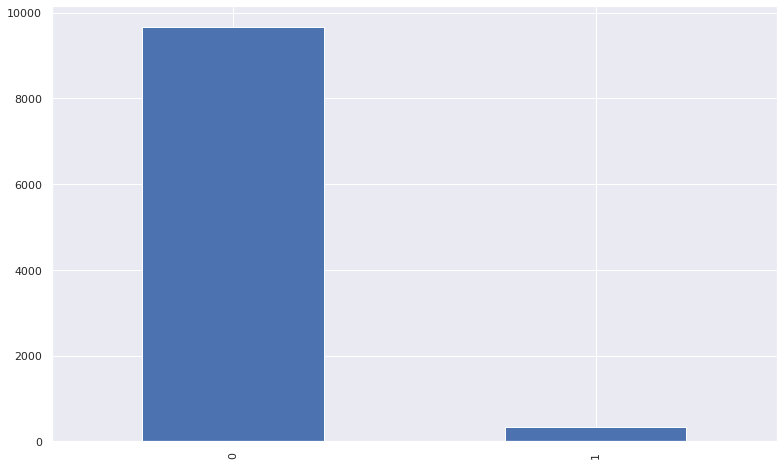

In [ ]:
df['MachineFailure'].value_counts().plot(kind='bar')
plt.ylabel('')
plt.show()

In [ ]:
print("Total number of failures are: ",(df.MachineFailure == 1).sum())

Total number of failures are:  339


1 = TWF
2 = HDF
3 = PWF
4 = OSF
5 = RNF


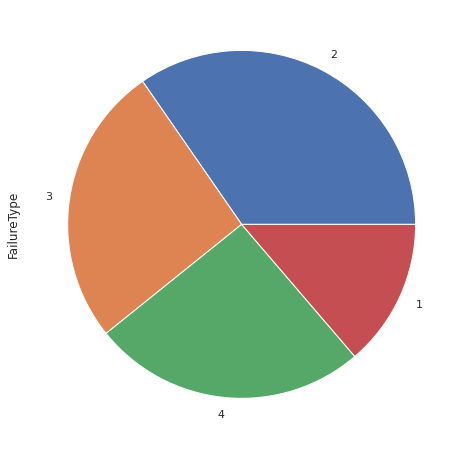

In [ ]:
y=df1['FailureType'][df1['FailureType']>0]
y.value_counts().plot(kind='pie')
labels=["1 = TWF","2 = HDF","3 = PWF","4 = OSF","5 = RNF"]
for i in labels:
  print(i)
plt.show()

In [ ]:
print("Total number of failures are: ",(df1.FailureType != 0).sum())

Total number of failures are:  306


Extracting Attribute Matrix

In [ ]:
X = df.drop(columns=['MachineFailure'])
X.head(5)

,AirTemperature[K],ProcessTemperature[K],RotationalSpeed[rpm],Torque[Nm],ToolWear[min]
0,298.1,308.6,1551,42.8,0
1,298.2,308.7,1408,46.3,3
2,298.1,308.5,1498,49.4,5
3,298.2,308.6,1433,39.5,7
4,298.2,308.7,1408,40.0,9


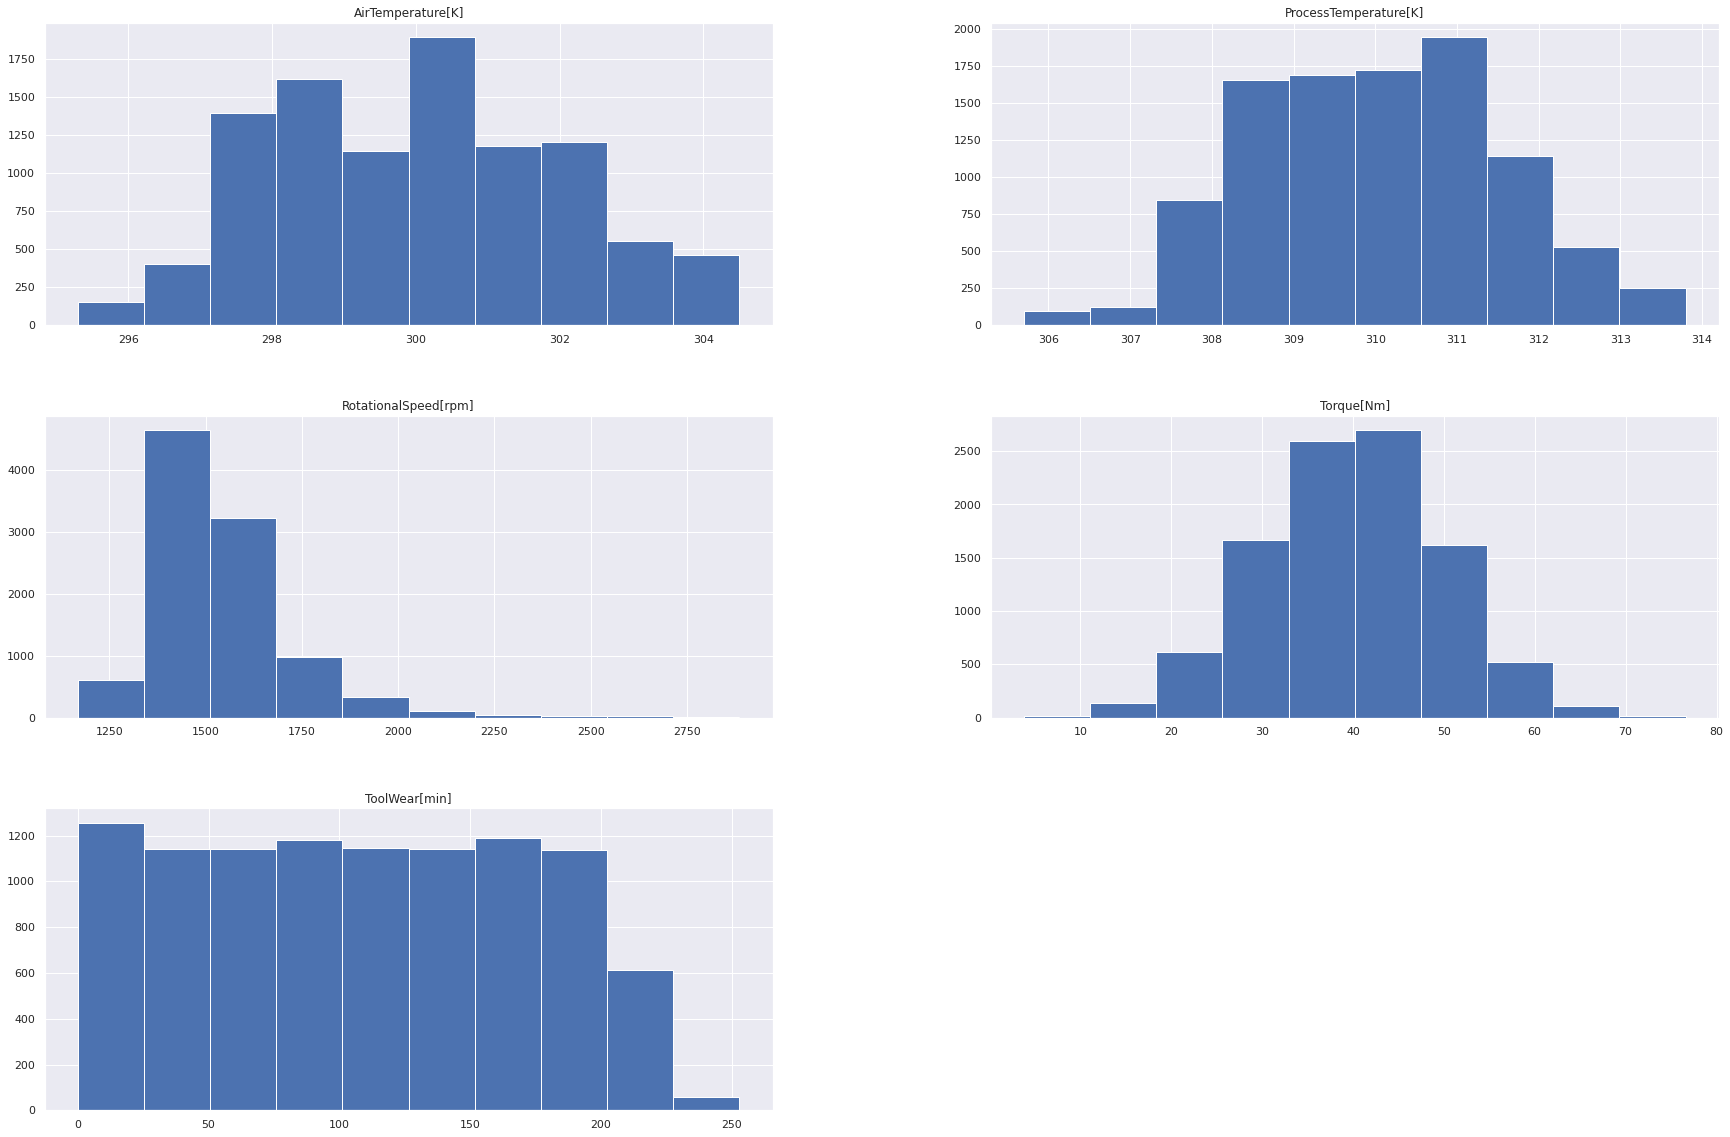

In [ ]:
# univariate data exploration
X.hist(figsize=(30,20),grid = True);

Unstandardized Data

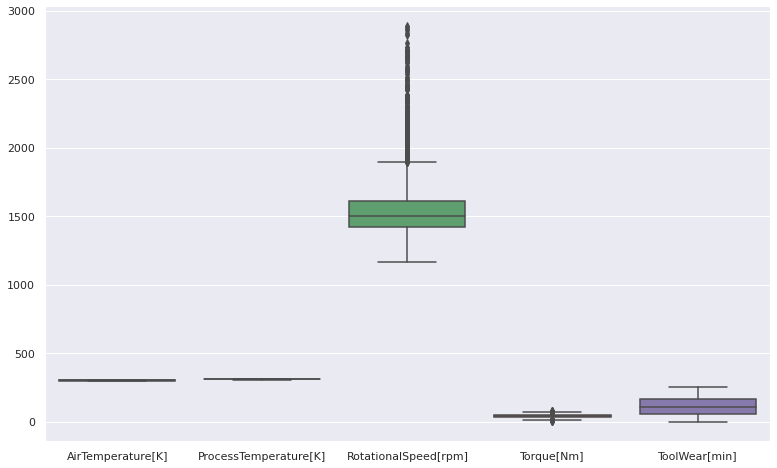

In [ ]:
sns.boxplot(data=X)

In [ ]:
# Generates a Standardized matrix with mean zero and variance is 1

Xs = StandardScaler().fit_transform(X)  
Xcols = X.columns
X = pd.DataFrame(Xs)
X.columns = Xcols
X.head(5)

,AirTemperature[K],ProcessTemperature[K],RotationalSpeed[rpm],Torque[Nm],ToolWear[min]
0,-0.952389,-0.947360,0.068185,0.282200,-1.695984
1,-0.902393,-0.879959,-0.729472,0.633308,-1.648852
2,-0.952389,-1.014761,-0.227450,0.944290,-1.617430
3,-0.902393,-0.947360,-0.590021,-0.048845,-1.586009
4,-0.902393,-0.879959,-0.729472,0.001313,-1.554588


In [ ]:
X.describe()

,AirTemperature[K],ProcessTemperature[K],RotationalSpeed[rpm],Torque[Nm],ToolWear[min]
count,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04
mean,6.965539e-17,3.841483e-15,-2.554568e-16,5.259244e-16,4.147793e-17
std,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00
min,-2.352278e+00,-2.901986e+00,-2.068196e+00,-3.630149e+00,-1.695984e+00
25%,-8.523974e-01,-8.125581e-01,-6.458012e-01,-6.808401e-01,-8.633176e-01
50%,4.753123e-02,6.365340e-02,-1.995597e-01,1.134481e-02,7.698234e-04
75%,7.474757e-01,7.376623e-01,4.084443e-01,6.834663e-01,8.491466e-01
max,2.247357e+00,2.557486e+00,7.514840e+00,3.672902e+00,2.278819e+00


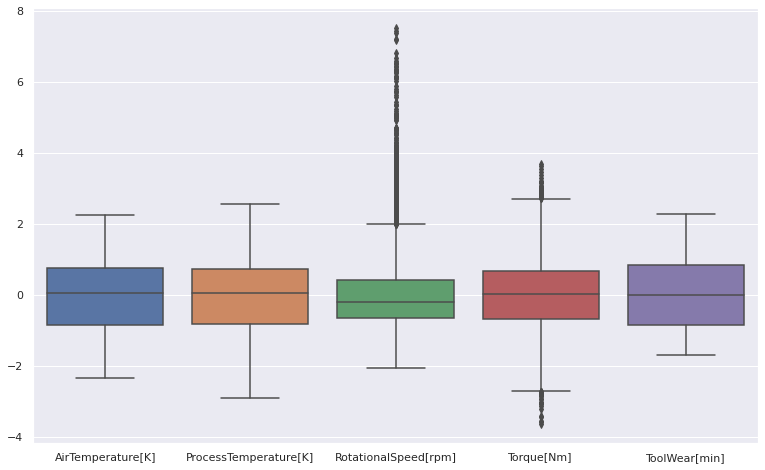

In [ ]:
sns.boxplot(data=X)

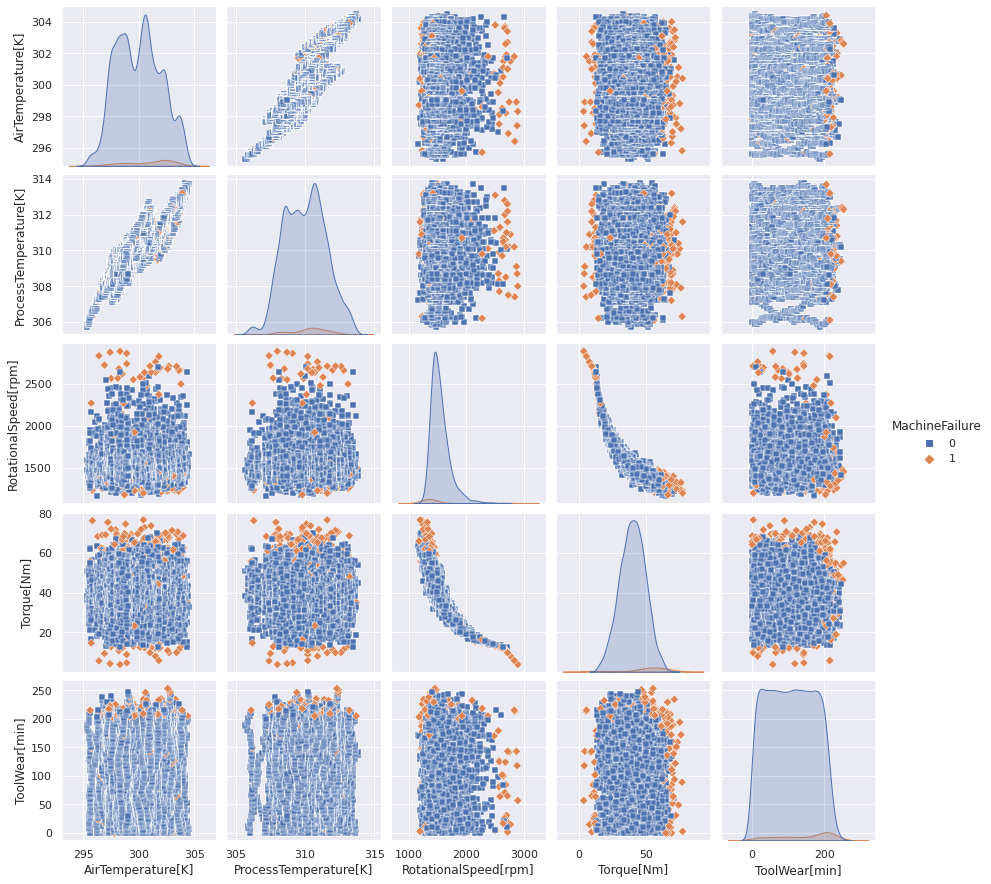

In [ ]:
sns.pairplot(df, hue='MachineFailure', markers=["s", "D"], kind="scatter")
plt.show()

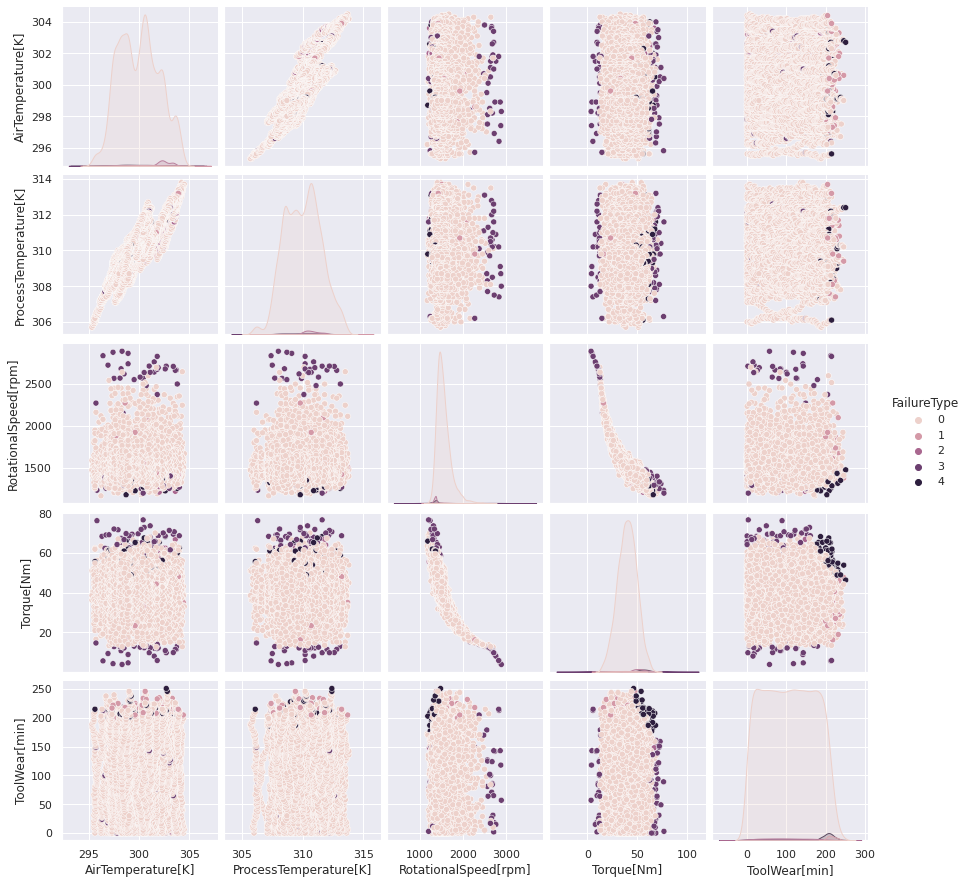

In [ ]:
sns.pairplot(df1, hue='FailureType', kind="scatter")
plt.show()

(array([0.5, 1.5, 2.5, 3.5, 4.5]), <a list of 5 Text major ticklabel objects>)

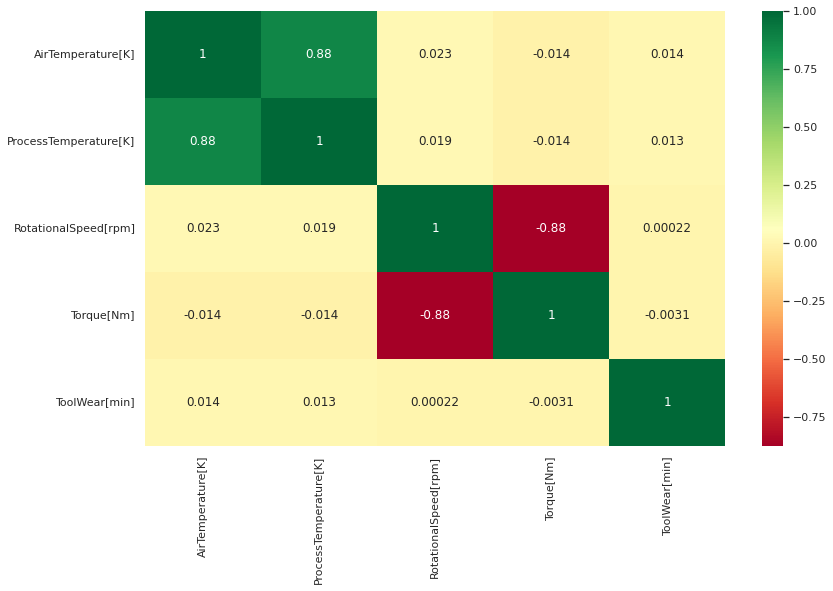

In [ ]:
sns.heatmap(X.corr(), cmap = 'RdYlGn', annot=True)
plt.yticks(rotation=0)

# Multi-Class Classification Model

In [ ]:
from pycaret.utils import enable_colab 
enable_colab()

Colab mode enabled.


In [ ]:
data = df1
data.reset_index(drop=True, inplace=True)
print('Data for Modeling: ' + str(data.shape))

Data for Modeling: (9976, 6)


In [ ]:
clfFT = setup(data=data, target='FailureType', train_size=0.7, session_id=666)

AttributeError: ignored

In [ ]:
bestModelFT = compare_models()
bestModelFT

In [ ]:
evaluate_model(bestModelFT)

# Binary Classification

In [ ]:
dataM = df
dataM.reset_index(drop=True, inplace=True)
print('Data for Modeling: ' + str(dataM.shape))

In [ ]:
clfMF = setup(data=dataM, target='RUL', train_size=0.7, session_id=666)

In [ ]:
bestModelMF = compare_models()
bestModelMF

In [ ]:
evaluate_model(bestModelMF)

# Remaining Useful Life

In [ ]:
dfTW = df['ToolWear[min]']
dfTW = dfTW.to_list()

unit_number = []
j=1
for i in range(len(dfTW)-1):
  if dfTW[i+1] < dfTW[i]:
    j = j+1
  unit_number.append(j)
unit_number.append(unit_number[-1])
df['unit_number'] = unit_number

In [ ]:
def add_RUL(df):
    group_unit = df.groupby(by='unit_number') 
    maxCyc = group_unit['ToolWear[min]'].max() 
    result = df.merge(maxCyc.to_frame(name='maxCyc'), left_on='unit_number', right_index=True)
    # Calculate remaining useful life for each row 
    RUL = result["maxCyc"] - result['ToolWear[min]']
    result["RUL"] = RUL
    # drop maxCycle as it's no longer needed 
    result = result.drop(columns=["maxCyc"]) 
    return result

In [ ]:
df = add_RUL(df)
df.head(10)

In [ ]:
maxRUL = df.groupby('unit_number').max().reset_index()
maxRUL["RUL"].hist()

In [ ]:
df["RUL"].describe()

# Regression

In [ ]:
reg = setup(data = dataM, target = 'RUL', session_id=666) 

In [ ]:
bestModelREG = compare_models()
bestModelREG

In [ ]:
evaluate_model(bestModelREG)